### Supervised Learning - Decision Trees

*Nikola Savic at gmail dot com*

## Imports

In [87]:
import time

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]


from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier

## Fetch, Split and Standardize Data

In [92]:
random_state = 2020

X_cred, y_cred = fetch_openml("credit-g", return_X_y=True)
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

X_cred = pd.DataFrame(X_cred)
y_cred = pd.DataFrame(y_cred)

X_mnist = pd.DataFrame(X_mnist)
y_mnist = pd.DataFrame(y_mnist)

# mapped_back_to_string_label = mapping.take(results)
y_cred[0], cred_mapping = pd.factorize(y_cred[0])
y_mnist[0], mnist_mapping = pd.factorize(y_mnist[0], sort=True)

# Create holdout test set
X_cred_train, X_cred_test, y_cred_train, y_cred_test = train_test_split(X_cred, y_cred, test_size=0.2,
                                                                        random_state=random_state,
                                                                        stratify=y_cred)

X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.2,
                                                                            random_state=random_state,
                                                                            stratify=y_mnist)

def get_data(data):
    return data["X"], data["y"], data["name"]

# Standardize
scaler_cred = StandardScaler()
scaler_cred.fit(X_cred_train)
X_cred_train = pd.DataFrame(scaler_cred.transform(X_cred_train), index=y_cred_train.index)
X_cred_test = pd.DataFrame(scaler_cred.transform(X_cred_test), index=y_cred_test.index)

X_mnist_train = pd.DataFrame(X_mnist_train / 255.0, index=y_mnist_train.index)
X_mnist_test = pd.DataFrame(X_mnist_test / 255.0, index=y_mnist_test.index)

# Create data sets
cred = {"X": X_cred_train, "y": y_cred_train, "name": "Credit Train"}
cred_test = {"X": X_cred_test, "y": y_cred_test, "name": "Credit Test"}

mnist = {"X": X_mnist_train, "y": y_mnist_train, "name": "MNIST Train"}
mnist_test = {"X": X_mnist_test, "y": y_mnist_test, "name": "MNIST Test"}

## Shared Functions

In [4]:
def print_cross_val(clf, data_set, cv=5, v=1):
    print(clf)
    X, y, name = get_data(data_set)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', verbose=v, n_jobs=-1)
    time.sleep(1)
    print("{} : {}".format(clf.__class__.__name__, name))
    print("Scores: ", scores, "Avg: ", np.mean(scores))

In [5]:
def build_confusion_matrix(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    disp = plot_confusion_matrix(clf, X, y, normalize="true", cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

In [6]:
def build_learning_curve(clf, data_set, scoring="accuracy", axes=None, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes, return_times=True, random_state=random_state
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")
    plt.show()

In [7]:
def build_validation_curve(clf, data_set, param_name, param_range, scoring="accuracy", cv=5):
    print(clf)
    X, y, name = get_data(data_set)
    
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv, n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    train_scores_max = np.max(train_scores_mean)
    train_scores_max_idx = np.argmax(train_scores_mean)
    train_scores_max_x = param_range[train_scores_max_idx]
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    test_scores_max = np.max(test_scores_mean)
    test_scores_max_idx = np.argmax(test_scores_mean)
    test_scores_max_x = param_range[test_scores_max_idx]

    plt.title("Validation Curve with " + clf.__class__.__name__ + " : " + name)
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw,
              marker="x",markeredgewidth=3, ms=8, markevery=[train_scores_max_idx])

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="darkorange", lw=lw)

    plt.plot(param_range, test_scores_mean, label="Test score", color="navy", lw=lw,
             marker="x", markeredgewidth=3, ms=8, markevery=[test_scores_max_idx])

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="navy", lw=lw)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.axvline(x=train_scores_max_x, linestyle="--", color="darkorange")
    plt.annotate("Train %0.2f" % train_scores_max, (train_scores_max_x, train_scores_max + 0.05))
   
    plt.axvline(x=test_scores_max_x, linestyle="--", color="navy")
    plt.annotate("Test %0.2f" % test_scores_max, (test_scores_max_x, test_scores_max + 0.05))

    plt.legend(loc="best")
    plt.show()

In [8]:
def print_gridsearch(data_set, parameters = {"random_state": random_state}, tuned_parameters={}, scores=["accuracy"]):
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

    best = []
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(DecisionTreeClassifier(**parameters), tuned_parameters, scoring=score, n_jobs=-1)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        best.append((clf.best_score_, clf.best_params_, clf.best_estimator_))
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

    print("Best parameters")
    for i in range(len(best)):
        print(scores[i])
        print(best[i])

In [69]:
def build_cred_precision_recall_curve(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=random_state)
    
    clf.fit(X_train, y_train)
    y_score = clf.predict(X_test)
    average_precision = average_precision_score(y_test, y_score)

    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_title('{0} Precision-Recall curve'.format(name))

## cross_val scores - accuracy

In [28]:
max_depth = 3
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
print_cross_val(ctree, cred)

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


DecisionTreeClassifier : Credit Train
Scores:  [0.7375  0.73125 0.74375 0.75625 0.7375 ] Avg:  0.74125


In [21]:
max_depth = 8
criterion = "entropy"
ccp_alpha = 0.0001
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
print_cross_val(mtree, mnist)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s finished


DecisionTreeClassifier : MNIST Train
Scores:  [0.82419643 0.82875    0.82017857 0.82696429 0.82160714] Avg:  0.8243392857142858


In [20]:
max_depth = 9
criterion = "entropy"
ccp_alpha = 0.0001
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
print_cross_val(mtree, mnist)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.3s finished


DecisionTreeClassifier : MNIST Train
Scores:  [0.85205357 0.85053571 0.84491071 0.85330357 0.84401786] Avg:  0.8489642857142858


In [22]:
max_depth = 10
criterion = "entropy"
ccp_alpha = 0.0001
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
print_cross_val(mtree, mnist)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.7s finished


DecisionTreeClassifier : MNIST Train
Scores:  [0.86901786 0.86589286 0.86125    0.86785714 0.85946429] Avg:  0.8646964285714287


In [23]:
max_depth = 12
criterion = "entropy"
ccp_alpha = 0.0001
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
print_cross_val(mtree, mnist)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.4s finished


DecisionTreeClassifier : MNIST Train
Scores:  [0.87446429 0.87285714 0.86651786 0.87446429 0.86892857] Avg:  0.8714464285714285


In [133]:
max_depth = 9
criterion = "entropy"
ccp_alpha = 0.0001
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               splitter="random",
                               random_state=random_state)
print_cross_val(mtree, mnist)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='random')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished


DecisionTreeClassifier : MNIST Train
Scores:  [0.82875    0.830625   0.83696429 0.83455357 0.82839286] Avg:  0.8318571428571427


## Learning Curves

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


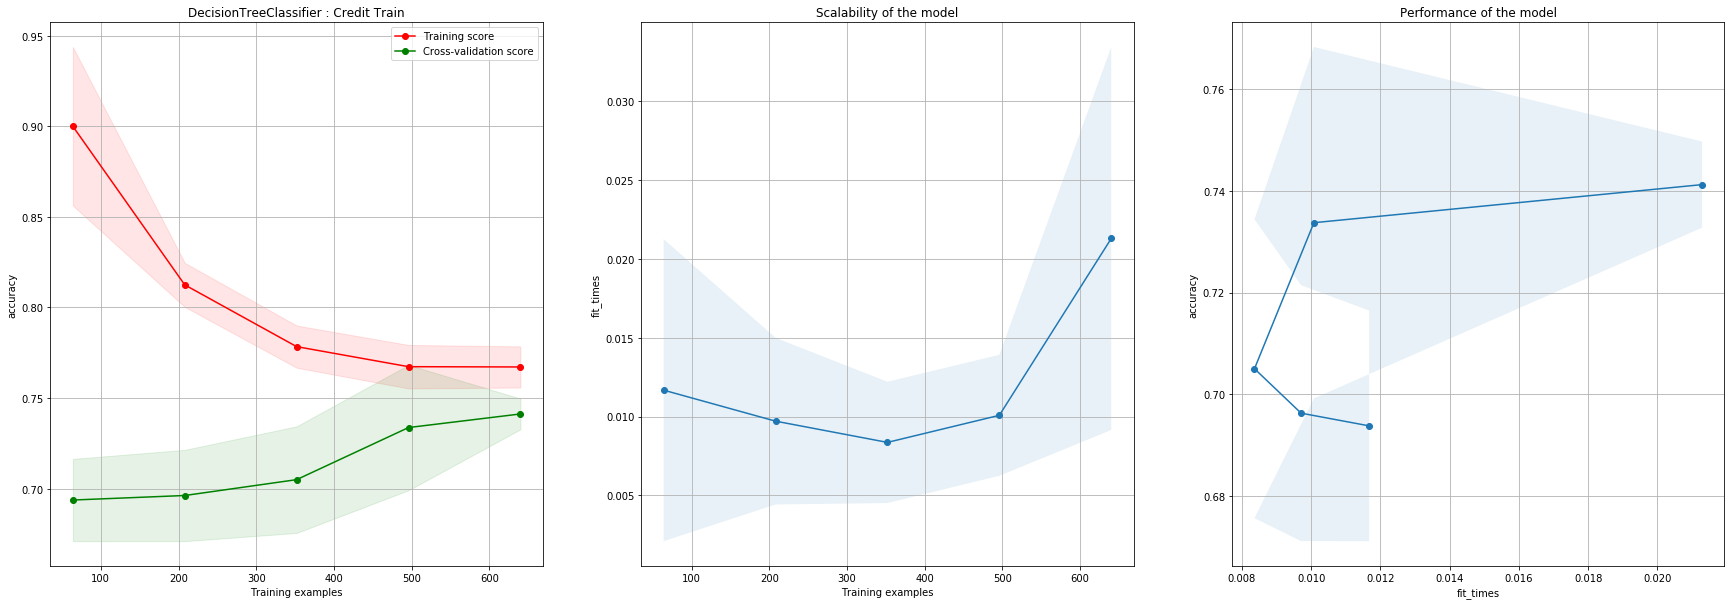

In [105]:
max_depth = 3
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_learning_curve(ctree, cred)

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


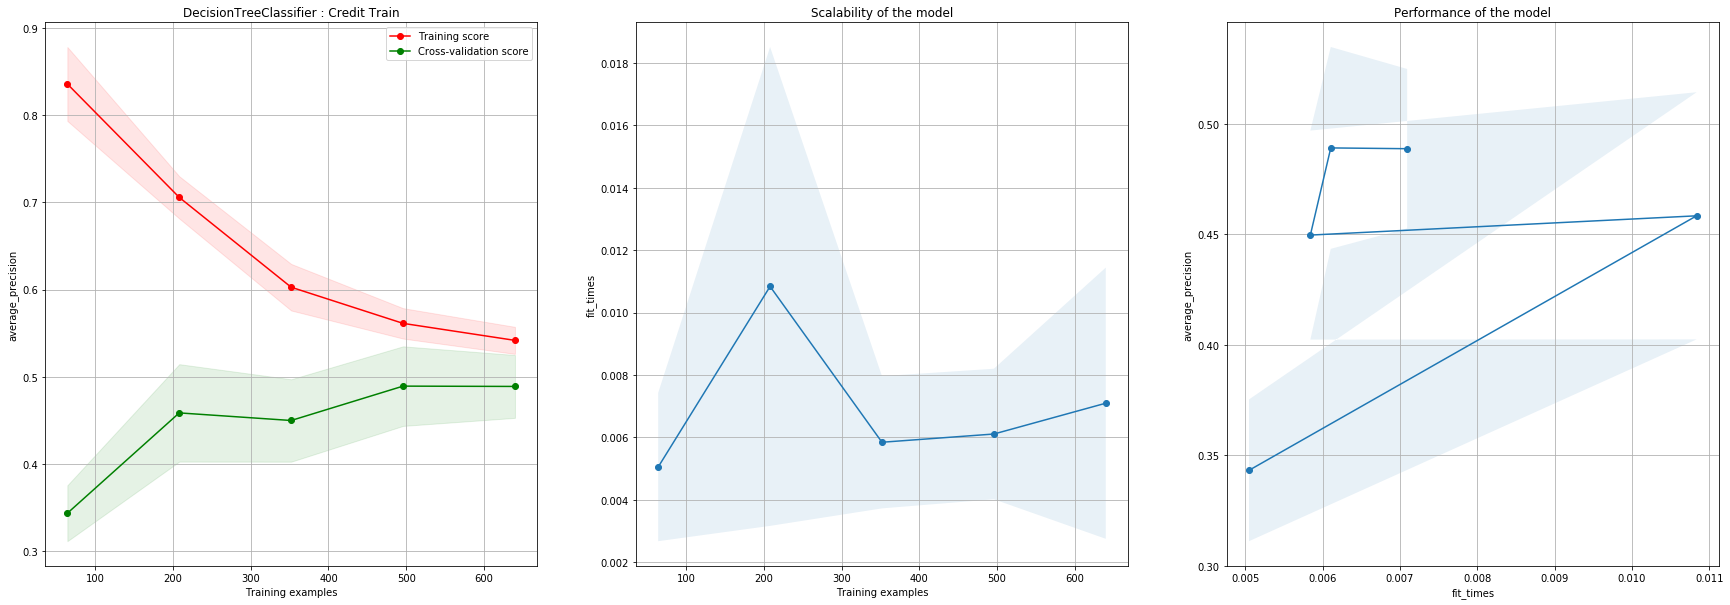

In [39]:
max_depth = 3
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_learning_curve(ctree, cred, scoring="average_precision")

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


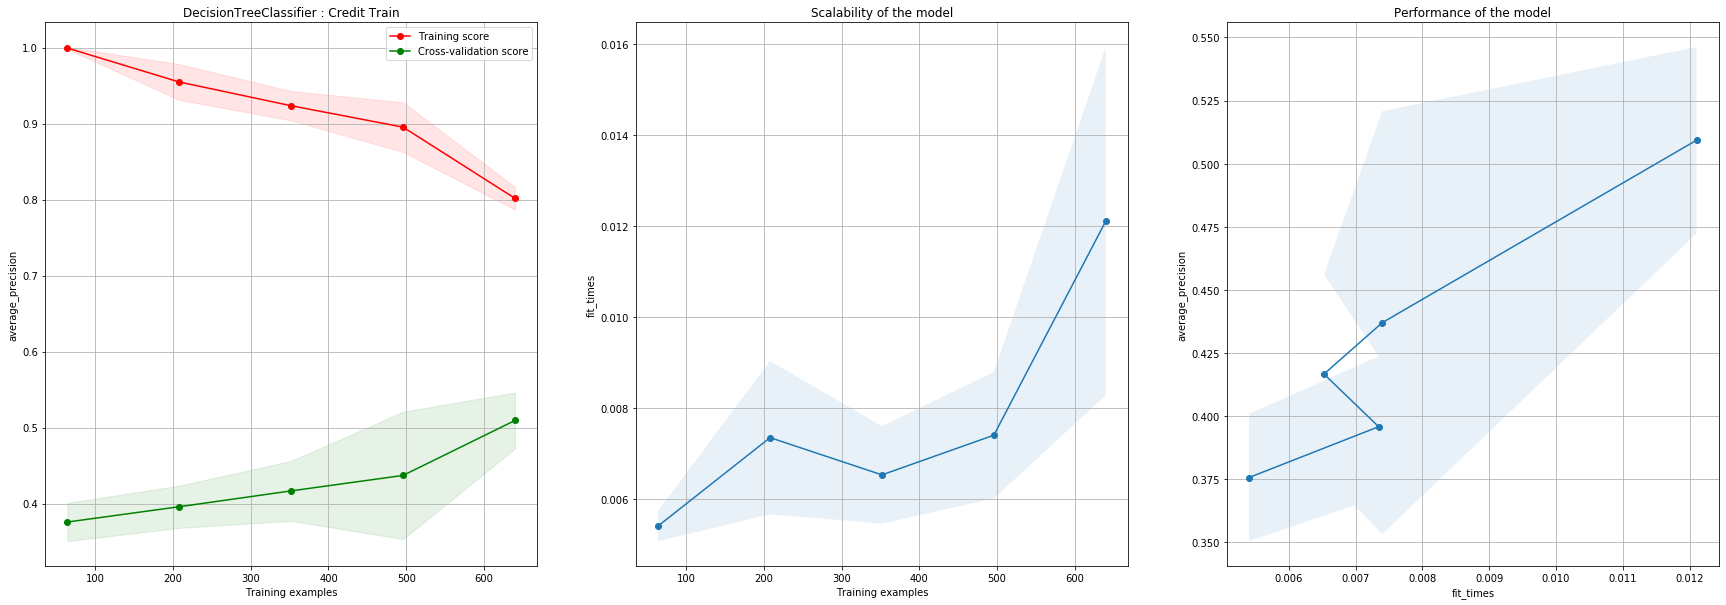

In [99]:
max_depth = 8
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_learning_curve(ctree, cred, scoring="average_precision")

DecisionTreeClassifier(ccp_alpha=0.004, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


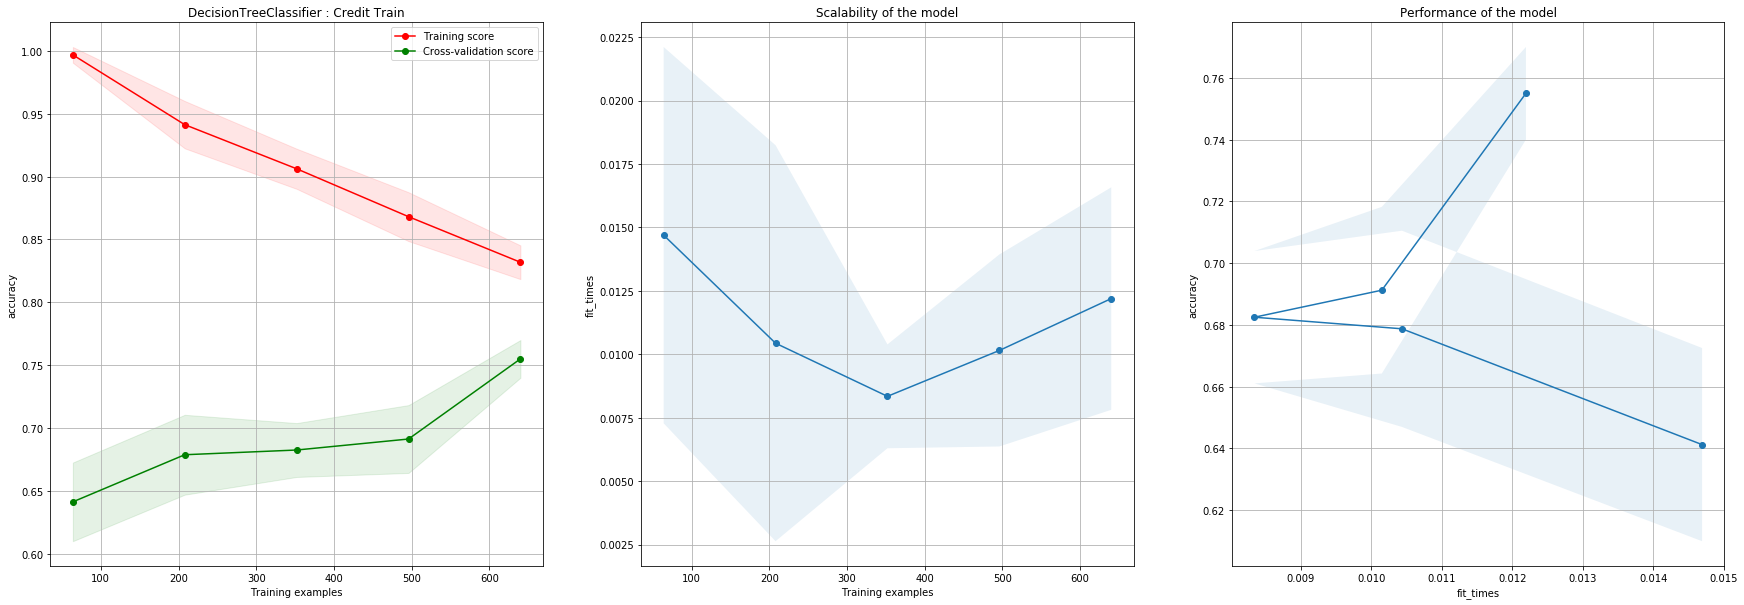

In [104]:
max_depth = 8
criterion = "gini"
ccp_alpha = 0.004
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_learning_curve(ctree, cred, scoring="accuracy")

DecisionTreeClassifier(ccp_alpha=0.004, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


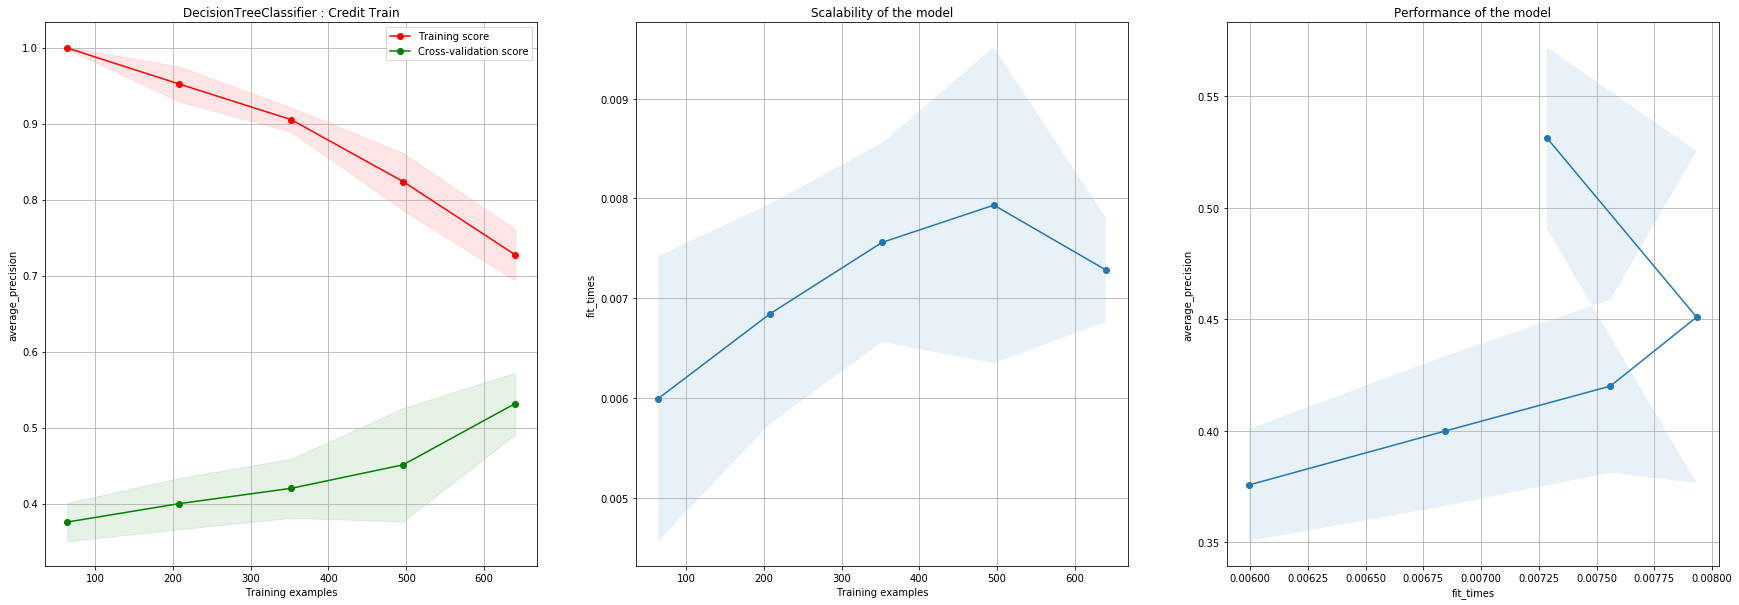

In [103]:
max_depth = 8
criterion = "gini"
ccp_alpha = 0.004
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_learning_curve(ctree, cred, scoring="average_precision")

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


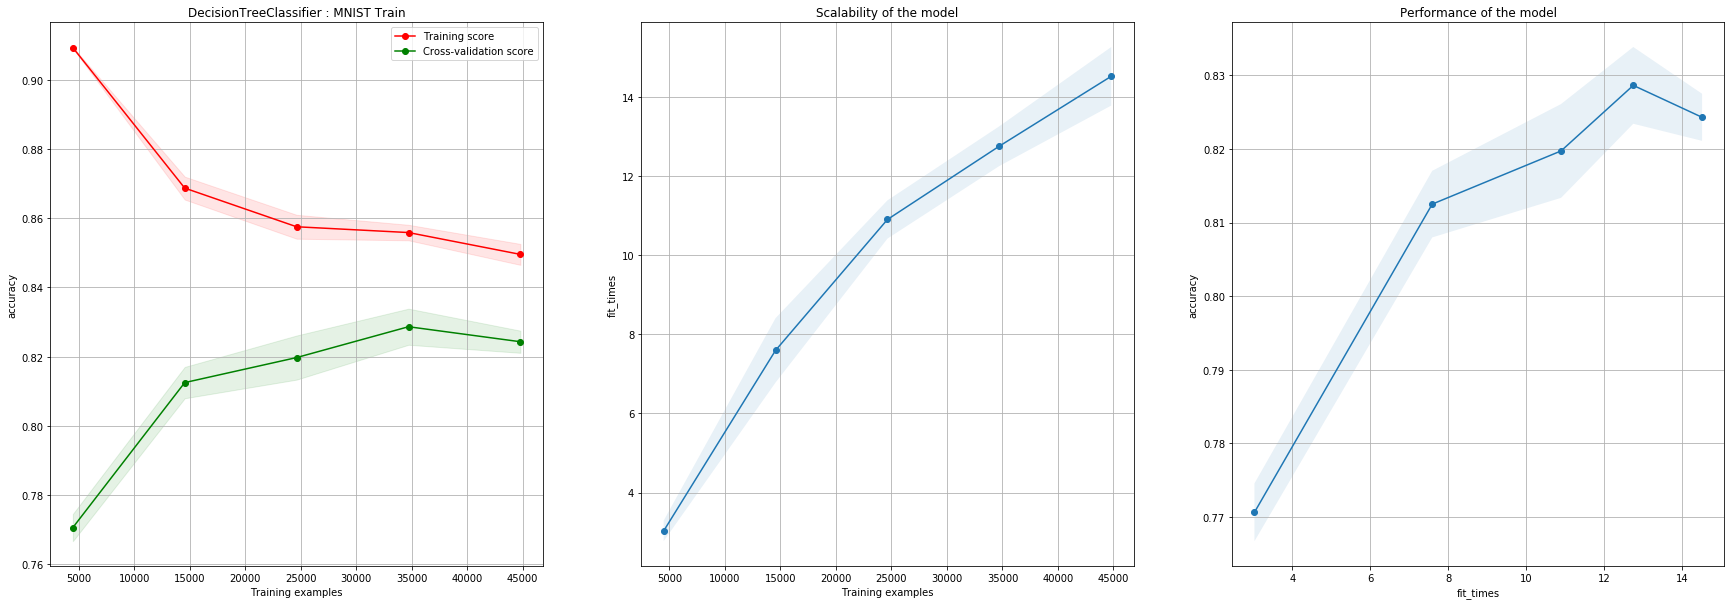

In [15]:
max_depth = 8
criterion = "entropy"
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               random_state=random_state)
build_learning_curve(mtree, mnist)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


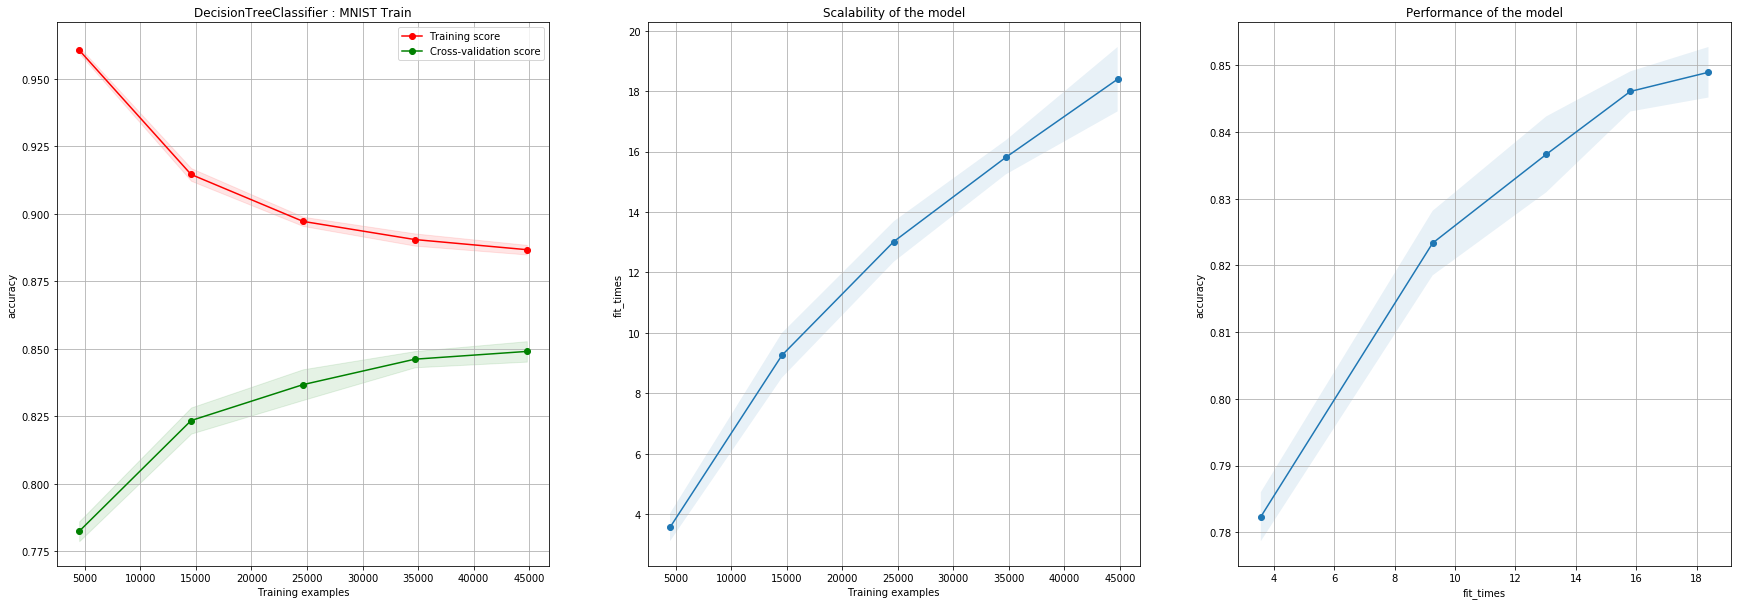

In [115]:
max_depth = 9
criterion = "entropy"
ccp_alpha = 0.0001
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_learning_curve(mtree, mnist)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


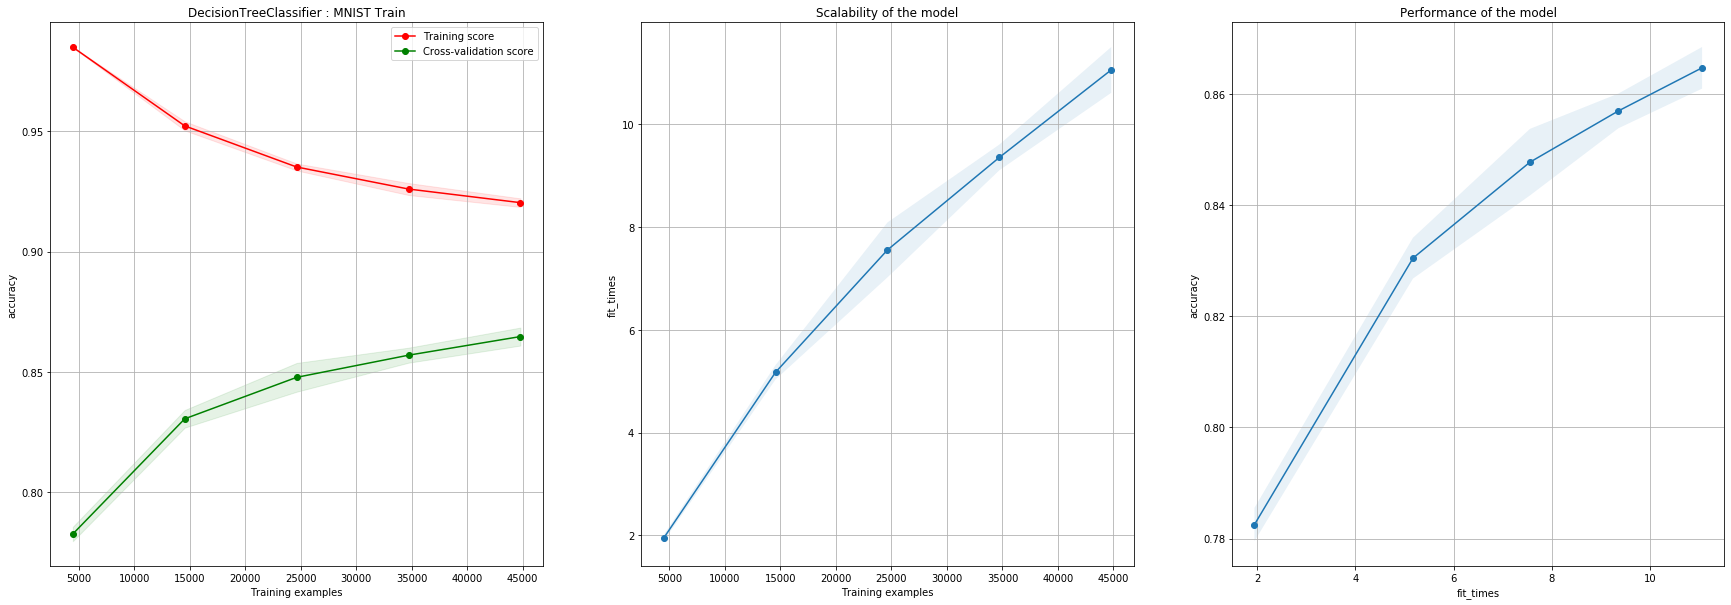

In [20]:
max_depth = 10
criterion = "entropy"
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               random_state=random_state)
build_learning_curve(mtree, mnist)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


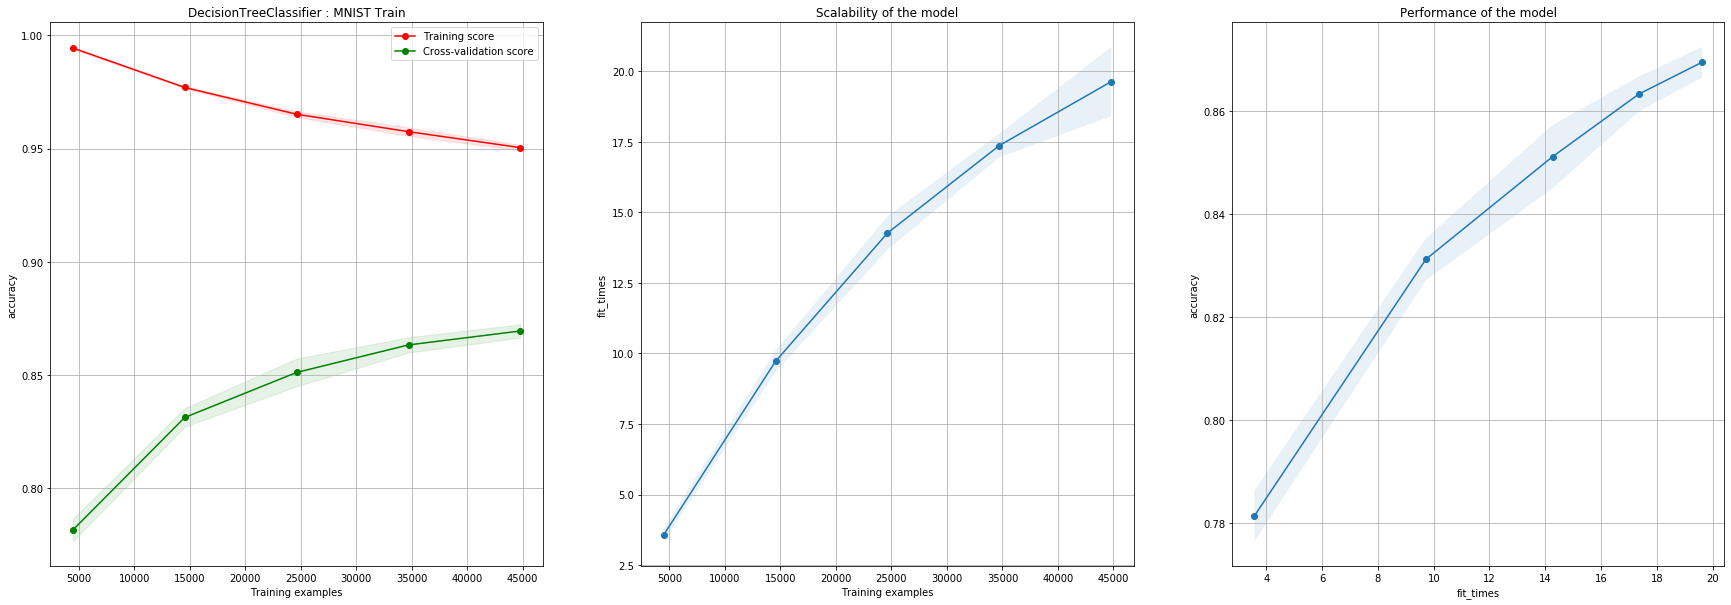

In [17]:
max_depth = 11
criterion = "entropy"
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               random_state=random_state)
build_learning_curve(mtree, mnist)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


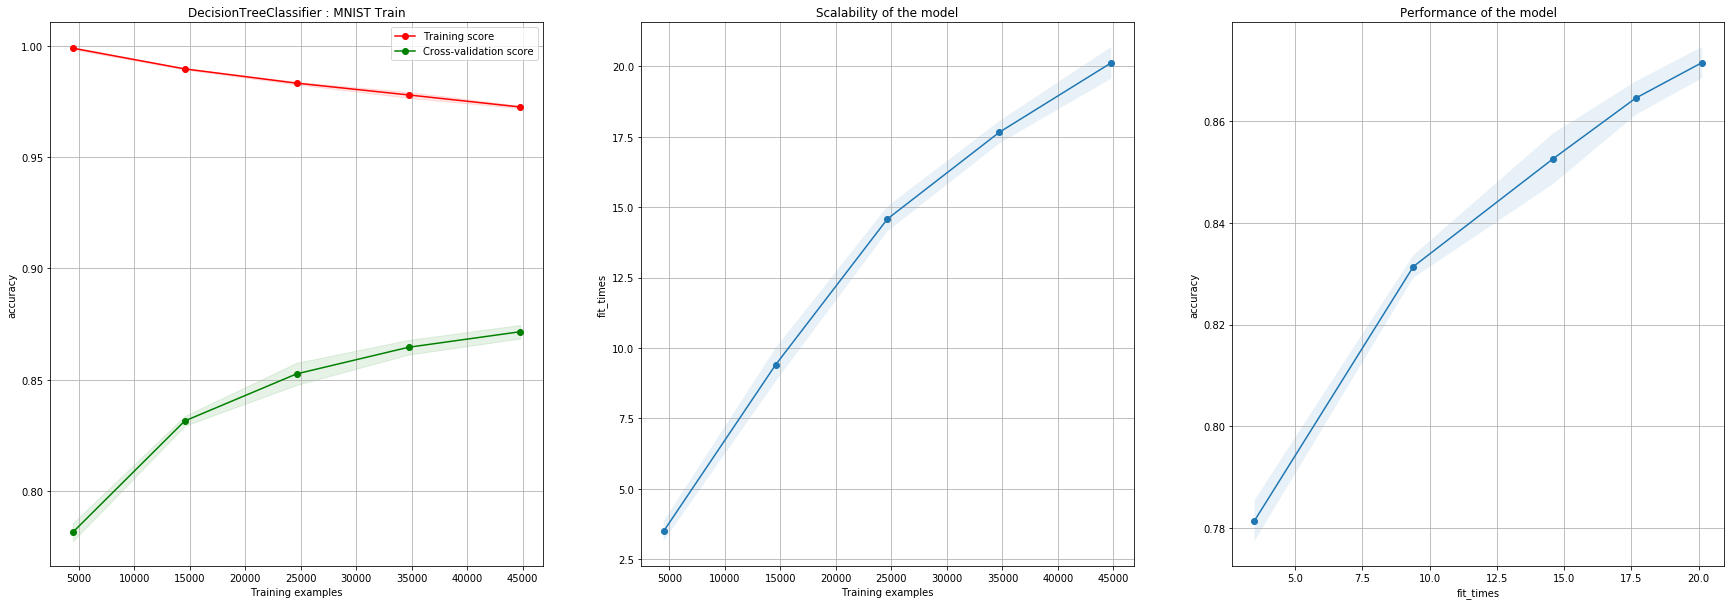

In [18]:
max_depth = 12
criterion = "entropy"
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               random_state=random_state)
build_learning_curve(mtree, mnist)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


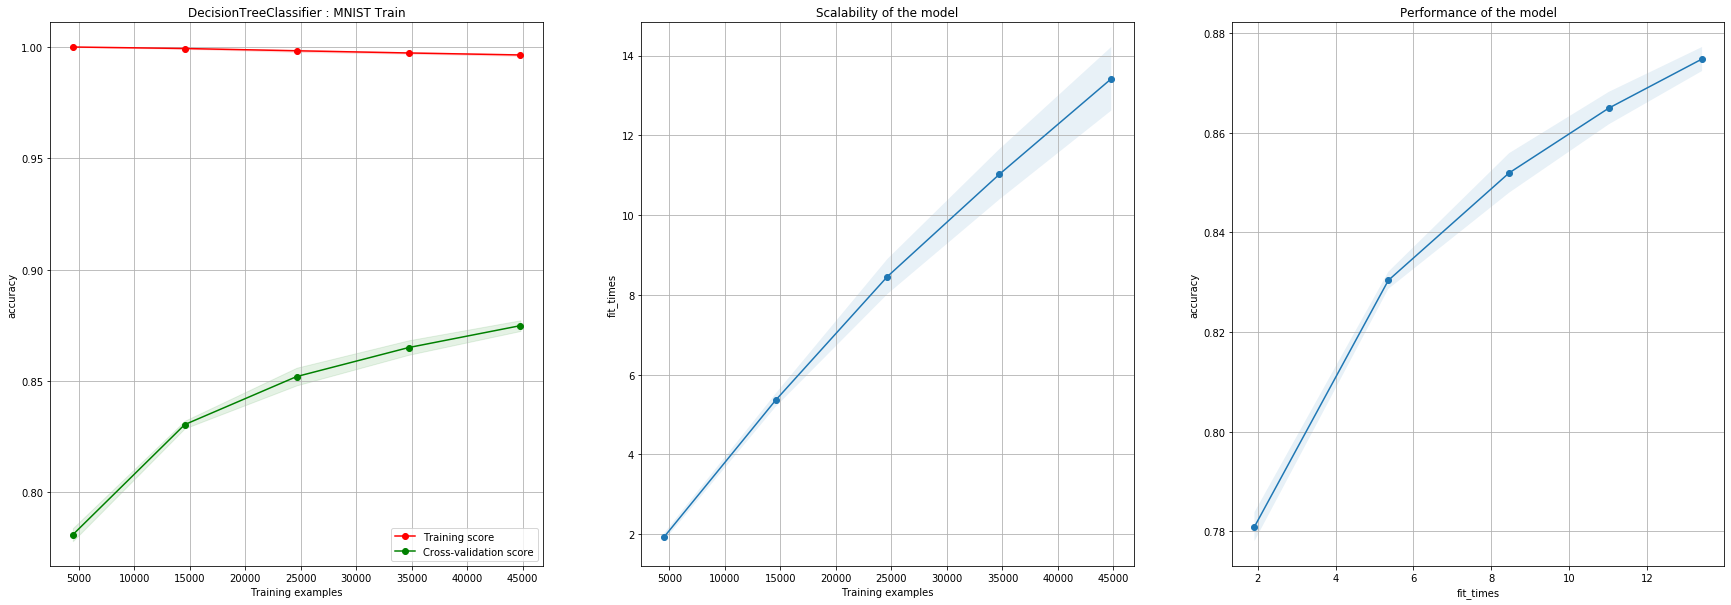

In [23]:
max_depth = 15
criterion = "entropy"
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               random_state=random_state)
build_learning_curve(mtree, mnist)

## Model Complexity Analysis

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


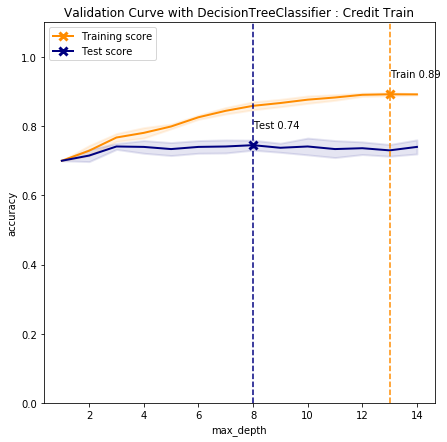

In [98]:
max_depth = 3
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_validation_curve(ctree, cred, param_name="max_depth", param_range=range(1,15))

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


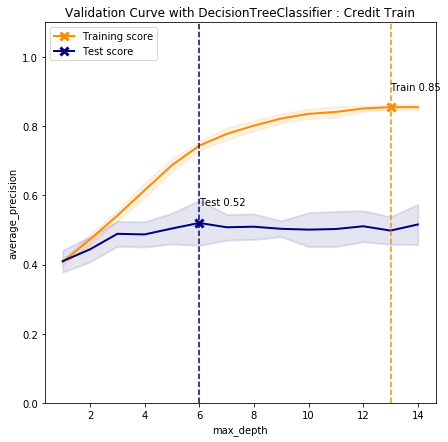

In [143]:
max_depth = 3
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_validation_curve(ctree, cred, param_name="max_depth", param_range=range(1,15), scoring="average_precision")

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


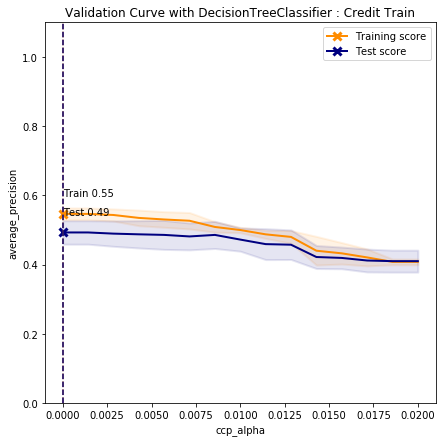

In [145]:
max_depth = 3
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_validation_curve(ctree, cred, param_name="ccp_alpha", param_range=np.linspace(0.0, 0.02, 15), scoring="average_precision")

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


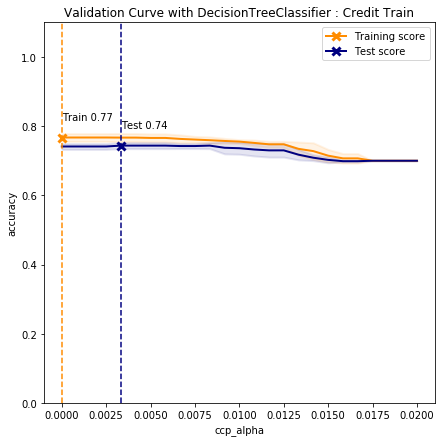

In [106]:
max_depth = 3
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_validation_curve(ctree, cred, param_name="ccp_alpha", param_range=np.linspace(0.0, 0.02, 25))

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


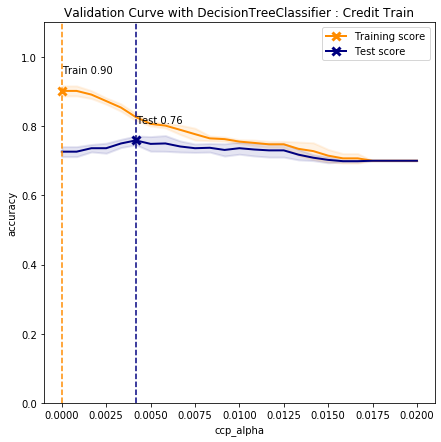

In [102]:
max_depth = 8
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_validation_curve(ctree, cred, param_name="ccp_alpha", param_range=np.linspace(0.0, 0.02, 25))

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


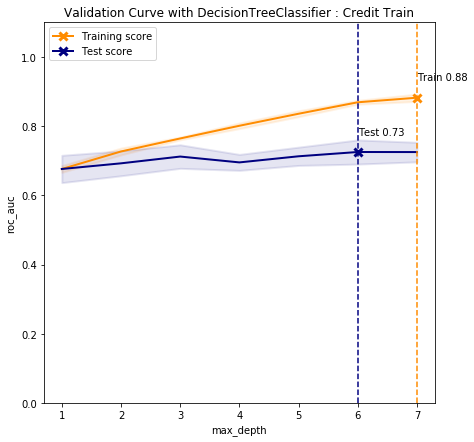

In [101]:
max_depth = 3
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
build_validation_curve(ctree, cred, scoring="roc_auc", param_name="max_depth", param_range=range(1,8))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


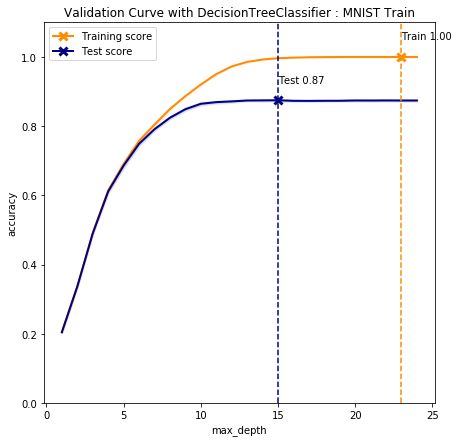

In [113]:
max_depth = 9
criterion = "entropy"
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               random_state=random_state)
build_validation_curve(mtree, mnist, param_name="max_depth", param_range=range(1,25))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


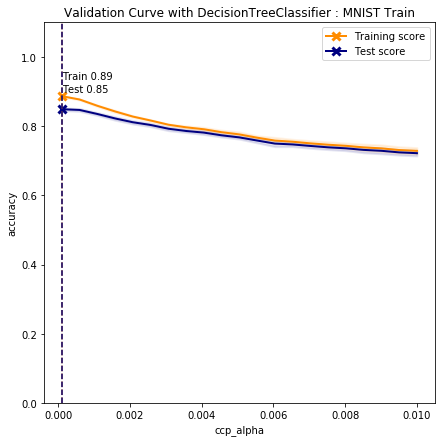

In [114]:
max_depth = 9
criterion = "entropy"
ccp_alpha = 0.
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               random_state=random_state)
build_validation_curve(mtree, mnist, param_name="ccp_alpha", param_range=np.linspace(0.0001, 0.01, 21))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')


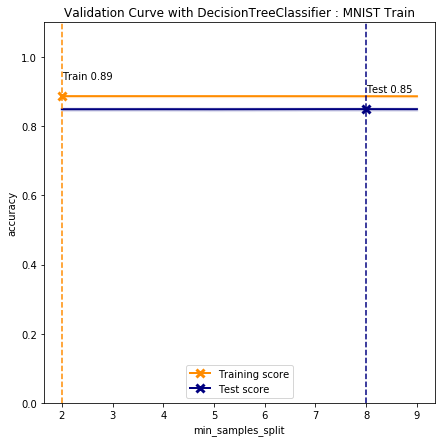

In [118]:
max_depth = 9
criterion = "entropy"
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               random_state=random_state)
build_validation_curve(mtree, mnist, param_name="min_samples_split", param_range=range(2,10))

## Grid Search

In [38]:
# Convert to code cell to run
parameters = {
    "random_state": random_state,
    "max_depth": 3,
    "criterion": "gini"
}
tuned_parameters =  {
    "ccp_alpha": np.linspace(0.0,0.01,50),
}
print_gridsearch(cred, parameters= parameters, tuned_parameters=tuned_parameters, scores = ["accuracy", "roc_auc"])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'ccp_alpha': 0.009795918367346938}

Grid scores on development set:

0.725 (+/-0.052) for {'ccp_alpha': 0.0}
0.725 (+/-0.052) for {'ccp_alpha': 0.00020408163265306123}
0.725 (+/-0.052) for {'ccp_alpha': 0.00040816326530612246}
0.725 (+/-0.052) for {'ccp_alpha': 0.0006122448979591836}
0.725 (+/-0.052) for {'ccp_alpha': 0.0008163265306122449}
0.725 (+/-0.052) for {'ccp_alpha': 0.0010204081632653062}
0.725 (+/-0.052) for {'ccp_alpha': 0.0012244897959183673}
0.725 (+/-0.052) for {'ccp_alpha': 0.0014285714285714286}
0.725 (+/-0.052) for {'ccp_alpha': 0.0016326530612244899}
0.725 (+/-0.052) for {'ccp_alpha': 0.0018367346938775511}
0.725 (+/-0.052) for {'ccp_alpha': 0.0020408163265306124}
0.725 (+/-0.052) for {'ccp_alpha': 0.0022448979591836735}
0.725 (+/-0.052) for {'ccp_alpha': 0.0024489795918367346}
0.725 (+/-0.052) for {'ccp_alpha': 0.002653061224489796}
0.725 (+/-0.052) for {'ccp_alpha': 0.00285714285

In [37]:
# Convert to code cell to run
parameters = {
    "criterion": "entropy"
}
tuned_parameters =  {
    "ccp_alpha": np.linspace(0.0,0.001,30),
    "max_depth": range(7,23)
}
print_gridsearch(mnist, parameters=parameters, tuned_parameters=tuned_parameters, scores = ["accuracy"])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'ccp_alpha': 0.0004827586206896552, 'max_depth': 20}

Grid scores on development set:

0.792 (+/-0.013) for {'ccp_alpha': 0.0, 'max_depth': 7}
0.821 (+/-0.014) for {'ccp_alpha': 0.0, 'max_depth': 8}
0.838 (+/-0.014) for {'ccp_alpha': 0.0, 'max_depth': 9}
0.846 (+/-0.016) for {'ccp_alpha': 0.0, 'max_depth': 10}
0.848 (+/-0.011) for {'ccp_alpha': 0.0, 'max_depth': 11}
0.848 (+/-0.015) for {'ccp_alpha': 0.0, 'max_depth': 12}
0.851 (+/-0.008) for {'ccp_alpha': 0.0, 'max_depth': 13}
0.851 (+/-0.011) for {'ccp_alpha': 0.0, 'max_depth': 14}
0.849 (+/-0.011) for {'ccp_alpha': 0.0, 'max_depth': 15}
0.851 (+/-0.011) for {'ccp_alpha': 0.0, 'max_depth': 16}
0.850 (+/-0.011) for {'ccp_alpha': 0.0, 'max_depth': 17}
0.851 (+/-0.009) for {'ccp_alpha': 0.0, 'max_depth': 18}
0.849 (+/-0.009) for {'ccp_alpha': 0.0, 'max_depth': 19}
0.850 (+/-0.011) for {'ccp_alpha': 0.0, 'max_depth': 20}
0.849 (+/-0.012) for {'ccp_alp

# Fit

In [71]:
# Credit Decision Tree
max_depth = 3
criterion = "gini"
ccp_alpha = 0.003
ctree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               random_state=random_state)
ctree

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')

In [134]:
# MNIST Decision Tree
max_depth = 9
criterion = "entropy"
ccp_alpha = 0.0001
min_samples_split = 2 # default
mtree = DecisionTreeClassifier(max_depth=max_depth,
                               criterion=criterion,
                               ccp_alpha=ccp_alpha,
                               min_samples_split=min_samples_split,
                               random_state=random_state)
mtree

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')

In [73]:
# Fit Credit
X_c, y_c, _ = get_data(cred)
ctree = ctree.fit(X_c, y_c)

In [135]:
# Fit MNIST
X_m, y_m, _ = get_data(mnist)
mtree = mtree.fit(X_m, y_m)

## Final Performance Analysis on TRAINING Set

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
Average precision-recall score: 0.341
DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
Classification report for classifier DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gin

/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


DecisionTreeClassifier : Credit Train
Scores:  [0.7375  0.73125 0.74375 0.75625 0.7375 ] Avg:  0.74125


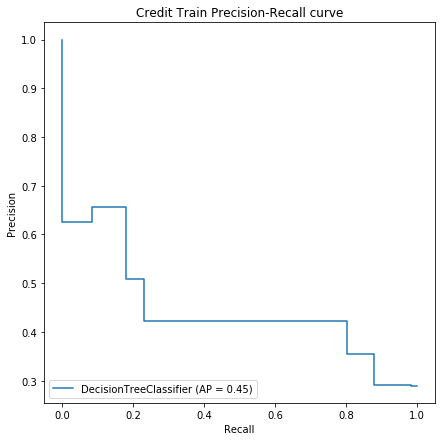

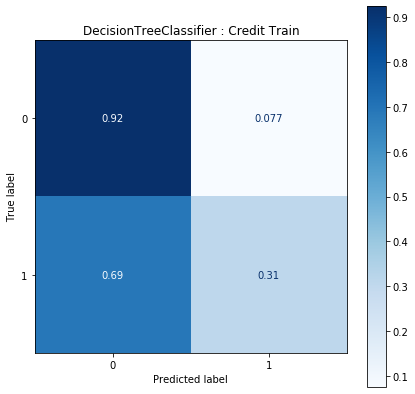

In [142]:
build_cred_precision_recall_curve(ctree, cred)
build_confusion_matrix(ctree, cred)
predicted_cred = ctree.predict(X_cred)
print("Classification report for classifier %s:\n\n%s\n" % (ctree, classification_report(y_cred, predicted_cred,digits=3)))
print_cross_val(ctree, cred)

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
Classification report for classifier DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best'):

              precision    recall  f1-score   support

           0       0.90      0.94      0.92   

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished


DecisionTreeClassifier : MNIST Train
Scores:  [0.85205357 0.85053571 0.84491071 0.85330357 0.84401786] Avg:  0.8489642857142858


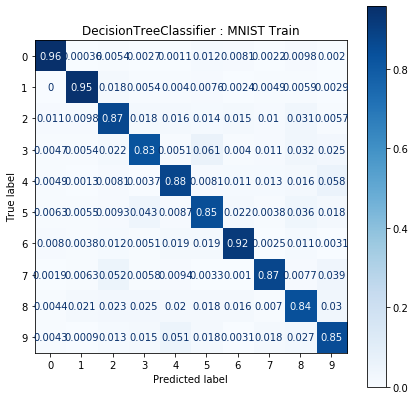

In [136]:
build_confusion_matrix(mtree, mnist)
predicted_mnist = mtree.predict(X_mnist)
print("Classification report for classifier %s:\n\n%s\n" % (mtree, classification_report(y_mnist, predicted_mnist)))
print_cross_val(mtree, mnist)

## Final Performance Analysis on TEST Set

DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
Average precision-recall score: 0.364
DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
Classification report for classifier DecisionTreeClassifier(ccp_alpha=0.003, class_weight=None, criterion='gin

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


DecisionTreeClassifier : Credit Test
Scores:  [0.75  0.7   0.6   0.75  0.575] Avg:  0.675


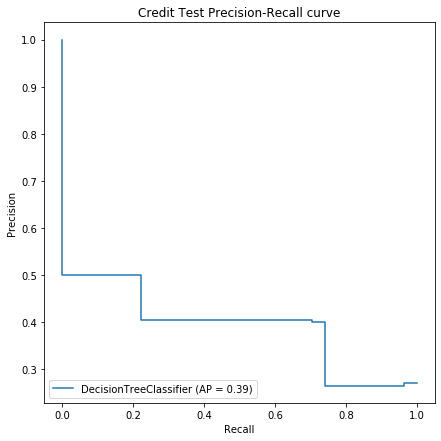

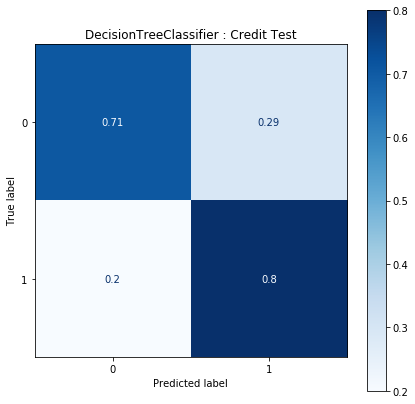

In [137]:
build_cred_precision_recall_curve(ctree, cred_test)
build_confusion_matrix(ctree, cred_test)
predicted_cred = ctree.predict(X_cred_test)
print("Classification report for classifier %s:\n\n%s\n" % (ctree, classification_report(y_cred_test, predicted_cred)))

DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best')
Classification report for classifier DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2020, splitter='best'):

              precision    recall  f1-score   support

           0       0.93      0.94      0.94   

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


DecisionTreeClassifier : MNIST Test
Scores:  [0.83142857 0.83642857 0.80964286 0.8325     0.81464286] Avg:  0.8249285714285713


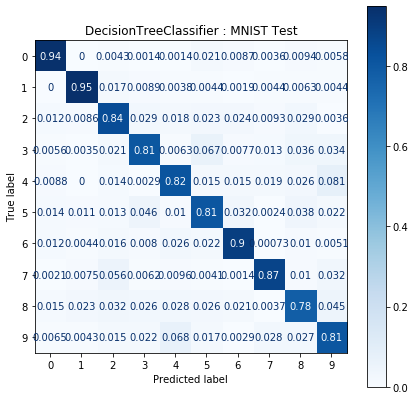

In [89]:
build_confusion_matrix(mtree, mnist_test)
predicted_mnist = mtree.predict(X_mnist_test)
print("Classification report for classifier %s:\n\n%s\n" % (mtree, classification_report(y_mnist_test, predicted_mnist)))